# ALgorytm najbliższego sąsiada

ALgorytm K-najbliższych sąsiadów (KNN) to prosty algorytm służący do klasyfikowania punktów danych na podstawie ich bliskości względem innych punktów danych. W przypadku nowego, niesklasyfikowanego punktu danych algorytm KNN sprawdza "k" najbliższych sąsiadów i klasyfikuje go do grupy w której jest więcej sąsiadów.

Wizualizacja algorytmu [tutaj](https://www.youtube.com/watch?v=gs9E7E0qOIc).

## Import bibliotek i wczytanie danych

Wykorzystany zostanie zbiór danych [breast_cancer.csv](data/breast_cancer.csv), pobrany ze strony [kaggle.com](https://www.kaggle.com/datasets/khansaafreen/breastdataset). 

Zadaniem modelu będzie klasyfikacja nowotworów piersi złośliwych (M) i łagodnych (B).

In [38]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

df = pd.read_csv('data/breast_cancer.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Przygotowanie danych

Na początku usuwam kolumnę *id*, ponieważ nie jest ona cechą niezależną, oraz kolumnę *Unnamed: 32*, która zawiera puste wartości.

Następnie zamieniam wartości w kolumnie *diagnosis* na 0 dla nowotworu łagodnego i 1 dla złośliwego.

Na koniec upewniam się, że zbiór nie zawiera pustych wartości.

In [39]:
df.drop(columns=["id", "Unnamed: 32"], inplace=True)
df["diagnosis"] = df["diagnosis"].map(lambda x: 1 if x == "M" else 0)
df.isnull().sum()

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

### Usunięcie kolumn nieskorelowanych

W celu poprawy wyniku klasyfikacji usuwam kolumny o współczynniku korelacji zbliżonym do 0.

In [40]:
df.corr()['diagnosis'].sort_values(ascending=False)

diagnosis                  1.000000
concave points_worst       0.793566
perimeter_worst            0.782914
concave points_mean        0.776614
radius_worst               0.776454
perimeter_mean             0.742636
area_worst                 0.733825
radius_mean                0.730029
area_mean                  0.708984
concavity_mean             0.696360
concavity_worst            0.659610
compactness_mean           0.596534
compactness_worst          0.590998
radius_se                  0.567134
perimeter_se               0.556141
area_se                    0.548236
texture_worst              0.456903
smoothness_worst           0.421465
symmetry_worst             0.416294
texture_mean               0.415185
concave points_se          0.408042
smoothness_mean            0.358560
symmetry_mean              0.330499
fractal_dimension_worst    0.323872
compactness_se             0.292999
concavity_se               0.253730
fractal_dimension_se       0.077972
symmetry_se               -0

In [41]:
df.drop(columns=["fractal_dimension_se", "symmetry_se", "texture_se", "fractal_dimension_mean", "smoothness_se"], inplace=True)

Dane są teraz gotowe do uczenia. Pozostaje tylko podział na zbiór cech niezależnych i zależnych. 

In [42]:
x = df.drop(columns=["diagnosis"])
y = df["diagnosis"]

## Uczenie modelu

Dane w zbiorze nie są tego samego rzędu wielkości, dlatego dla polepszenia jakości klasyfikacji skaluje je za pomocą **StandardScaler()**. Skalowanie usuwa dominację cech o większych wartościach.

Do uczenia modelu wykorzystuję klasę **KNeighborsClassifier**. Jako argument podaję liczbę "k", czyli liczbę sąsiadów do porówania.

In [43]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

model = Pipeline([
    ('scaler', StandardScaler()),
    ('kNN', KNeighborsClassifier(n_neighbors=3))
])
model.fit(x_train, y_train)

,steps,"[('scaler', ...), ('kNN', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_neighbors,3
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30


## Mierzenie skuteczności modelu

Graficznym sposobem przedstawienia poprawności klasyfikacji jest wygenerowanie **macierzy pomyłek (confusion matrix)**.

Sprawdza przewidywania modelu z rzeczywistymi etykietami, przedstawiając liczbę prawidłowych i błędnych klasyfikacji.

Nasza macierz składa się z 4 pól:

**True Positives (TP)**: liczba poprawnie sklasyfikowanych pozytywnych przypadków.

**True Negatives (TN)**: liczba poprawnie sklasyfikowanych negatywnych przypadków.

**False Positives (FP)**: liczba przypadków, które zostały błędnie sklasyfikowane jako pozytywne.

**False Negatives (FN)**: liczba przypadków, które zostały błędnie sklasyfikowane jako negatywne.

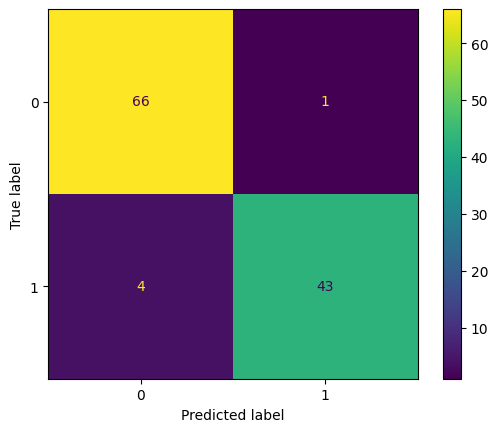

In [44]:
y_pred = model.predict(x_test)

cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(cm).plot()
plt.show()

Dodatkowymi metrykami wykorzystywanymi do analizy modelu są:

**Precyzja (precision)**: odsetek poprawnych przewidywań pozytywnej klasy spośród wszystkich przypadków oznaczonych przez model jako pozytywne.

$$ Precyzja = \frac{TP}{TP + FP} $$

**Czułość (recall)**: odsetek rzeczywistych przypadków pozytywnych, które model poprawnie wykrył spośród wszystkich rzeczywistych pozytywów.

$$ Czulosc = \frac{TP}{TP + FN} $$

**Wskaźnik F1**: średnia harmoniczna precyzji i czułości, łącząca obie miary w jedną wartość.
$$ F1 = \frac{2*Precyzja*Czulosc}{Precyzja + Czulosc} $$

**Dokładność (accuracy)**: odsetek poprawnie sklasyfikowanych próbek (zarówno pozytywnych, jak i negatywnych) spośród wszystkich próbek.
$$ Dokladnosc = \frac{TP + TN}{Wszystkie} $$

**Support**: zlicza ile przypadków wystąpiło w zbiorze.

**Macro avg**: średnia arytmetyczna metryk dla każdej klasy, traktując je równoważnie.

**Weighted avg**: średnia ważona według liczby próbek (supportu) w każdej klasie.


In [45]:
print(classification_report(y_test, y_pred, target_names=["Łagodny nowotwór", "Złośliwy nowotwór"]))

                   precision    recall  f1-score   support

 Łagodny nowotwór       0.94      0.99      0.96        67
Złośliwy nowotwór       0.98      0.91      0.95        47

         accuracy                           0.96       114
        macro avg       0.96      0.95      0.95       114
     weighted avg       0.96      0.96      0.96       114

